# Machine Translation with Attention is all you need
## Results:
Validation Loss: 1.613  
Validation perplexity: 5.016  
Bleu score:  35.33

## Hyperparameters:  
Epochs: 10  
Loss function:  CrossEntropy  
Optimizer:  Adam  
LR: 0.0005  




# Architecture

![](https://raw.githubusercontent.com/bentrevett/pytorch-seq2seq/9479fcb532214ad26fd4bda9fcf081a05e1aaf4e/assets/transformer1.png)

To check what kind of GPU is available run the below command, if this gives error go to Runtime -> Change runtime type and select GPU from the dropdown

In [ ]:
!nvidia-smi

Sun May 23 15:05:42 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

We need to install older version of torchtext because the latest version does not have Multi30k dataset

In [ ]:
!pip install --upgrade torchtext==0.4.0

     |████████████████████████████████| 61kB 8.6MB/s 
  Found existing installation: torchtext 0.9.1
    Uninstalling torchtext-0.9.1:
      Successfully uninstalled torchtext-0.9.1


## Imports

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np

import random
import math
import time

Set the SEED value to replicate the results in the same session

In [ ]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## Download spacy for tokenization

In [ ]:
!python -m spacy download en
!python -m spacy download de

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')
     |████████████████████████████████| 14.9MB 21.0MB/s 
  Created wheel for de-core-news-sm: filename=de_core_news_sm-2.2.5-cp37-none-any.whl size=14907057 sha256=4c68789ac374d628a1c32f590dc692c5cf5988824b53844cc12b0a133a75cddb
  Stored in directory: /tmp/pip-ephem-wheel-cache-jmttbrva/wheels/ba/3f/ed/d4aa8e45e7191b7f32db4bfad565e7da1edbf05c916ca7a1ca
Successfully built de-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/de_core_news_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/de
You can now load the model via spacy.load('de')


Loading 'de' (german) and 'en' (english) spacy tokenizer

In [ ]:
spacy_de = spacy.load('de')
spacy_en = spacy.load('en')

In [ ]:
text = 'Hi, it is a lovely day'
tokenizer = [tok.text for tok in spacy_de.tokenizer(text)]
tokenizer

['Hi', ',', 'it', 'is', 'a', 'lovely', 'day']

## Create tokenize methods 
Tokenize each word in a sentence

In [ ]:
def tokenize_de(text):
    """
    Tokenizes German text from a string into a list of strings
    """
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

In [ ]:
SRC = Field(tokenize = tokenize_de, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

In [ ]:
train_data, valid_data, test_data = Multi30k.splits(exts=('.de', '.en'), 
                                                    fields=(SRC, TRG))

downloading training.tar.gz


training.tar.gz: 100%|██████████| 1.21M/1.21M [00:00<00:00, 1.59MB/s]


downloading validation.tar.gz


validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 277kB/s]


downloading mmt_task1_test2016.tar.gz


mmt_task1_test2016.tar.gz: 100%|██████████| 66.2k/66.2k [00:00<00:00, 267kB/s]


## Building vocabulary

min_freq = 2  
Those words which has frequency less than 2 are not added in the vocabulary

In [ ]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Create the iterator 

In [ ]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
     batch_size = BATCH_SIZE,
     device = device)

## Encoder

![](https://raw.githubusercontent.com/bentrevett/pytorch-seq2seq/9479fcb532214ad26fd4bda9fcf081a05e1aaf4e/assets/transformer-encoder.png)

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, pf_dim, dropout, n_heads, n_layer, device, max_sentence_length=100):
        super().__init__()

        self.tok_embedding = nn.Embedding(input_dim, hidden_dim)
        self.pos_embedding = nn.Embedding(max_sentence_length, hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.encoder_layer = nn.ModuleList(
            [EncoderLayer(hidden_dim, pf_dim, n_heads, dropout, device) for _ in range(n_layer)]
        )

        self.scale = torch.sqrt(torch.FloatTensor([hidden_dim])).to(device)
        self.device = device

    def forward(self, src, src_mask):
        batch_size, src_len = src.shape[0], src.shape[1]

        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        input = self.dropout((self.tok_embedding(src)*self.scale) + self.pos_embedding(pos))

        for layer in self.encoder_layer:
            input = layer(input, src_mask)

        return input

In [ ]:
src_len=10
batch_size=4

#pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
x = torch.arange(0, src_len)
x, x.size()

(tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), torch.Size([10]))

In [ ]:
x = torch.arange(0, src_len).unsqueeze(0)
x, x.size()

(tensor([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]), torch.Size([1, 10]))

In [ ]:
x = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1) //
x, x.size()

(tensor([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
         [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
         [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
         [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]), torch.Size([4, 10]))

In [ ]:
x = torch.tensor([1, 2, 3])
x.repeat(4, 5)

tensor([[1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3],
        [1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3],
        [1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3],
        [1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3]])

In [ ]:
x.repeat(4, 1)

tensor([[1, 2, 3],
        [1, 2, 3],
        [1, 2, 3],
        [1, 2, 3]])

In [ ]:
 x.repeat(4, 2)

tensor([[1, 2, 3, 1, 2, 3],
        [1, 2, 3, 1, 2, 3],
        [1, 2, 3, 1, 2, 3],
        [1, 2, 3, 1, 2, 3]])

In [ ]:
z = x.repeat(4, 2, 2)
z, z.size()

(tensor([[[1, 2, 3, 1, 2, 3],
          [1, 2, 3, 1, 2, 3]],
 
         [[1, 2, 3, 1, 2, 3],
          [1, 2, 3, 1, 2, 3]],
 
         [[1, 2, 3, 1, 2, 3],
          [1, 2, 3, 1, 2, 3]],
 
         [[1, 2, 3, 1, 2, 3],
          [1, 2, 3, 1, 2, 3]]]), torch.Size([4, 2, 6]))

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, hidden_dim, pf_dim, n_heads, dropout, device):
        super().__init__()

        self.multi_head_attention = MultiHeadAttention(hidden_dim, n_heads, dropout, device)
        self.norm = nn.LayerNorm(hidden_dim)
        self.feed_forward = FeedForward(hidden_dim, pf_dim, dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, input_mask):

        attention_output, _ = self.multi_head_attention(input, input, input, input_mask)
        norm_output_1 = self.norm(input + self.dropout(attention_output))

        feed_forward_output = self.feed_forward(norm_output_1)
        norm_output_2 = self.norm(norm_output_1 + self.dropout(feed_forward_output))

        return norm_output_2


In [ ]:
a = torch.arange(0,5)
b = a
a+b # element-wise addition

tensor([0, 2, 4, 6, 8])

# MultiHeadAttention
        
![](https://raw.githubusercontent.com/bentrevett/pytorch-seq2seq/9479fcb532214ad26fd4bda9fcf081a05e1aaf4e/assets/transformer-attention.png)

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, hidden_dim, n_heads, dropout, device):
        super().__init__()

        assert hidden_dim % n_heads == 0

        self.hidden_dim = hidden_dim
        self.n_heads = n_heads
        self.head_dim = hidden_dim // n_heads

        self.fc_q = nn.Linear(hidden_dim, hidden_dim)
        self.fc_k = nn.Linear(hidden_dim, hidden_dim)
        self.fc_v = nn.Linear(hidden_dim, hidden_dim)

        self.fc_o = nn.Linear(hidden_dim, hidden_dim)

        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)


    def forward(self, query, key, value, mask=None):
        batch_size = query.shape[0]

        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)

        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0,2,1,3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0,2,1,3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0,2,1,3)

        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale

        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)

        attention = torch.softmax(energy, dim = -1)

        x = torch.matmul(self.dropout(attention), V)
        x = x.permute(0, 2, 1 ,3).contiguous() 
        # contiguous helps in allocating values nearby in memory, so that it will be quite fast to fetch those values

        x = x.view(batch_size, -1, self.hidden_dim)

        x = self.fc_o(x)

        return x, attention

In [ ]:
a = torch.arange(0,5).unsqueeze(0).repeat(4,1)
b = torch.arange(1,6).unsqueeze(0).repeat(4,1).permute(1,0)
print(a.size(), b.size())
print(a)
print(b)
torch.matmul(a,b)

torch.Size([4, 5]) torch.Size([5, 4])
tensor([[0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4]])
tensor([[1, 1, 1, 1],
        [2, 2, 2, 2],
        [3, 3, 3, 3],
        [4, 4, 4, 4],
        [5, 5, 5, 5]])


tensor([[40, 40, 40, 40],
        [40, 40, 40, 40],
        [40, 40, 40, 40],
        [40, 40, 40, 40]])

In [ ]:
mask =(a != 0)
a

tensor([[0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4]])

In [ ]:
a.masked_fill(mask == 0, -1e10) # place -1e10 wherever 0 is present

tensor([[-10000000000,            1,            2,            3,            4],
        [-10000000000,            1,            2,            3,            4],
        [-10000000000,            1,            2,            3,            4],
        [-10000000000,            1,            2,            3,            4]])

## FeedForward

In [ ]:
class FeedForward(nn.Module):
    def __init__(self, hidden_dim, pf_dim, dropout):
        super().__init__()

        self.fc_1 = nn.Linear(hidden_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hidden_dim)

        self.dropout = nn.Dropout(dropout)


    def forward(self, x):
        x = self.dropout(torch.relu(self.fc_1(x)))
        x = self.fc_2(x)

        return x

## Decoder

![](https://raw.githubusercontent.com/bentrevett/pytorch-seq2seq/9479fcb532214ad26fd4bda9fcf081a05e1aaf4e/assets/transformer-decoder.png)

In [ ]:
class Decoder(nn.Module):
    def __init__(self, output_dim, hidden_dim, pf_dim, dropout, n_heads, n_layers, device, max_sentence_length=100):
        super().__init__()

        self.tok_embedding = nn.Embedding(output_dim, hidden_dim)
        self.pos_embedding = nn.Embedding(max_sentence_length, hidden_dim)
        self.decoder_layer = nn.ModuleList(
            [Decoderlayer(hidden_dim, pf_dim, n_heads, dropout, device) for _ in range(n_layers)]                               
        )
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

        self.device = device
        self.scale = torch.sqrt(torch.FloatTensor([hidden_dim])).to(device)


    def forward(self, encoder_output, trg, trg_mask, src_mask):
        batch_size, trg_len = trg.shape[0], trg.shape[1]
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)

        input = self.dropout((self.tok_embedding(trg) *self.scale) + self.pos_embedding(pos))

        for layer in self.decoder_layer:
            input, attention = layer(encoder_output, input, trg_mask, src_mask)

        output = self.fc(input)

        return output, attention


In [ ]:
class Decoderlayer(nn.Module):
    def __init__(self, hidden_dim, pf_dim, n_heads, dropout, device):
        super().__init__()

        self.masked_multi_head_attention = MultiHeadAttention(hidden_dim, n_heads, dropout, device)
        self.self_attention = MultiHeadAttention(hidden_dim, n_heads, dropout, device)

        self.feed_forward = FeedForward(hidden_dim, pf_dim, dropout)

        self.masked_multi_head_attention_norm = nn.LayerNorm(hidden_dim)
        self.self_attention_norm = nn.LayerNorm(hidden_dim)
        self.feed_forward_norm = nn.LayerNorm(hidden_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, encoder_output, trg, trg_mask, src_mask):
        masked_multi_head_attention_output, _ = self.masked_multi_head_attention(trg, trg, trg, trg_mask)
        norm_output_1 = self.masked_multi_head_attention_norm(trg + self.dropout(masked_multi_head_attention_output))

        self_attention_output, attention = self.self_attention(norm_output_1, encoder_output, encoder_output, src_mask)
        norm_output_2 = self.self_attention_norm(norm_output_1 + self.dropout(self_attention_output))

        feed_forward_output = self.feed_forward(norm_output_2)
        norm_output_3 = self.feed_forward_norm(norm_output_2 + self.dropout(feed_forward_output))

        return norm_output_3, attention


Sentence length: 4

1000        
1100        
1110      
1111   

Sentence length: 3

1000      
1100       
1110   
1110   


In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, trg_pad_idx, device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx

        self.device = device

    def create_src_mask(self, src):
        mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        return mask

    def create_trg_mask(self, trg):
        trg_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        trg_len = trg.shape[1]

        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device=self.device)).bool()

        mask = trg_mask & trg_sub_mask

        return mask

    def forward(self, src, trg):

        src_mask = self.create_src_mask(src)
        trg_mask = self.create_trg_mask(trg)

        encoder_output = self.encoder(src, src_mask)
        decoder_output, attention = self.decoder(encoder_output, trg, trg_mask, src_mask)

        return decoder_output, attention


In [ ]:
a = torch.arange(0,4).unsqueeze(0).repeat(4,1)
print("a: ",a)
a_mask =(a != 0)
mask = a.masked_fill(a_mask == 0, -1e10) # place -1e10 wherever 0 is present
m_len = a.shape[0]

m_sub_mask = torch.tril(torch.ones((m_len, m_len)))
print(m_sub_mask)
m_sub_mask = m_sub_mask.bool()
m_sub_mask

a:  tensor([[0, 1, 2, 3],
        [0, 1, 2, 3],
        [0, 1, 2, 3],
        [0, 1, 2, 3]])
tensor([[1., 0., 0., 0.],
        [1., 1., 0., 0.],
        [1., 1., 1., 0.],
        [1., 1., 1., 1.]])


tensor([[ True, False, False, False],
        [ True,  True, False, False],
        [ True,  True,  True, False],
        [ True,  True,  True,  True]])

In [ ]:
m_sub_mask.size(), a_mask.size()

(torch.Size([4, 4]), torch.Size([4, 4]))

In [ ]:
m_sub_mask & a_mask

tensor([[False, False, False, False],
        [False,  True, False, False],
        [False,  True,  True, False],
        [False,  True,  True,  True]])

In [ ]:
ENCODER_INPUT_DIM = len(SRC.vocab)
DECODER_OUTPUT_DIM = len(TRG.vocab)

ENCODER_HIDDEN_DIM = 256
DECODER_HIDDEN_DIM = 256

ENCODER_PF_DIM = 512 
DECODER_PF_DIM = 512 

ENCODER_DROPOUT = 0.1
DECODER_DROPOUT = 0.1

ENCODER_N_HEADS = 8
DECODER_N_HEADS = 8

ENCODER_N_LAYERS = 3
DECODER_N_LAYERS = 3

DEVICE = device
MAX_SENTENCE_LENGTH = 100

Encoder = Encoder(ENCODER_INPUT_DIM, ENCODER_HIDDEN_DIM, ENCODER_PF_DIM, ENCODER_DROPOUT, ENCODER_N_HEADS, ENCODER_N_LAYERS, DEVICE, MAX_SENTENCE_LENGTH)
Decoder = Decoder(DECODER_OUTPUT_DIM, DECODER_HIDDEN_DIM, DECODER_PF_DIM, DECODER_DROPOUT, DECODER_N_HEADS, DECODER_N_LAYERS, DEVICE, MAX_SENTENCE_LENGTH)

In [ ]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

In [ ]:
model = Seq2Seq(Encoder, Decoder, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model)} trainable parameters')

The model has 9037317 trainable parameters


In [ ]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

model.apply(initialize_weights)

Seq2Seq(
  (encoder): Encoder(
    (tok_embedding): Embedding(7855, 256)
    (pos_embedding): Embedding(100, 256)
    (dropout): Dropout(p=0.1, inplace=False)
    (encoder_layer): ModuleList(
      (0): EncoderLayer(
        (multi_head_attention): MultiHeadAttention(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (feed_forward): FeedForward(
          (fc_1): Linear(in_features=256, out_features=512, bias=True)
          (fc_2): Linear(in_features=512, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): EncoderL

In [ ]:
LEARNING_RATE = 0.0005
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss(ignore_index=TRG_PAD_IDX)

In [ ]:
def train(model, iterator, optimizer, criterion, clip):
    epoch_loss = 0
    model.train()

    for idx, batch in enumerate(iterator):

        src = batch.src
        trg = batch.trg

        optimizer.zero_grad()

        output, _ = model(src, trg[:,:-1])

        output_dim = output.shape[-1]

        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)

        loss = criterion(output, trg)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    model.eval()

    with torch.no_grad():
        for idx, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output, _ = model(src, trg[:,:-1])

            output_dim = output.shape[-1]

            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)

            loss = criterion(output, trg)

            epoch_loss += loss.item()

        return epoch_loss / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    duration = end_time-start_time
    mins = duration//60
    secs = int(duration - (mins*60))
    return mins, secs

In [ ]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut6-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 0.0m 18s
	Train Loss: 4.189 | Train PPL:  65.976
	 Val. Loss: 3.010 |  Val. PPL:  20.281
Epoch: 02 | Time: 0.0m 18s
	Train Loss: 2.803 | Train PPL:  16.490
	 Val. Loss: 2.297 |  Val. PPL:   9.949
Epoch: 03 | Time: 0.0m 18s
	Train Loss: 2.221 | Train PPL:   9.220
	 Val. Loss: 1.966 |  Val. PPL:   7.145
Epoch: 04 | Time: 0.0m 18s
	Train Loss: 1.874 | Train PPL:   6.516
	 Val. Loss: 1.801 |  Val. PPL:   6.058
Epoch: 05 | Time: 0.0m 18s
	Train Loss: 1.631 | Train PPL:   5.106
	 Val. Loss: 1.703 |  Val. PPL:   5.491
Epoch: 06 | Time: 0.0m 18s
	Train Loss: 1.443 | Train PPL:   4.235
	 Val. Loss: 1.640 |  Val. PPL:   5.156
Epoch: 07 | Time: 0.0m 18s
	Train Loss: 1.294 | Train PPL:   3.646
	 Val. Loss: 1.613 |  Val. PPL:   5.016
Epoch: 08 | Time: 0.0m 18s
	Train Loss: 1.171 | Train PPL:   3.224
	 Val. Loss: 1.613 |  Val. PPL:   5.018
Epoch: 09 | Time: 0.0m 18s
	Train Loss: 1.061 | Train PPL:   2.889
	 Val. Loss: 1.621 |  Val. PPL:   5.060
Epoch: 10 | Time: 0.0m 18s
	Train Los

In [ ]:
model.load_state_dict(torch.load('tut6-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 1.673 | Test PPL:   5.327 |


In [ ]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):
    
    model.eval()
        
    if isinstance(sentence, str):
        nlp = spacy.load('de')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    
    src_mask = model.create_src_mask(src_tensor)
    
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        trg_mask = model.create_trg_mask(trg_tensor)
        
        with torch.no_grad():
            output, attention = model.decoder(enc_src, trg_tensor, trg_mask, src_mask)
        
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attention

In [ ]:
def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    
    assert n_rows * n_cols == n_heads
    
    fig = plt.figure(figsize=(15,25))
    
    for i in range(n_heads):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                           rotation=45)
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [ ]:
example_idx = 8

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['eine', 'frau', 'mit', 'einer', 'großen', 'geldbörse', 'geht', 'an', 'einem', 'tor', 'vorbei', '.']
trg = ['a', 'woman', 'with', 'a', 'large', 'purse', 'is', 'walking', 'by', 'a', 'gate', '.']


predicted trg = ['a', 'woman', 'with', 'a', 'large', 'purse', 'walks', 'past', 'a', 'gate', '.', '<eos>']


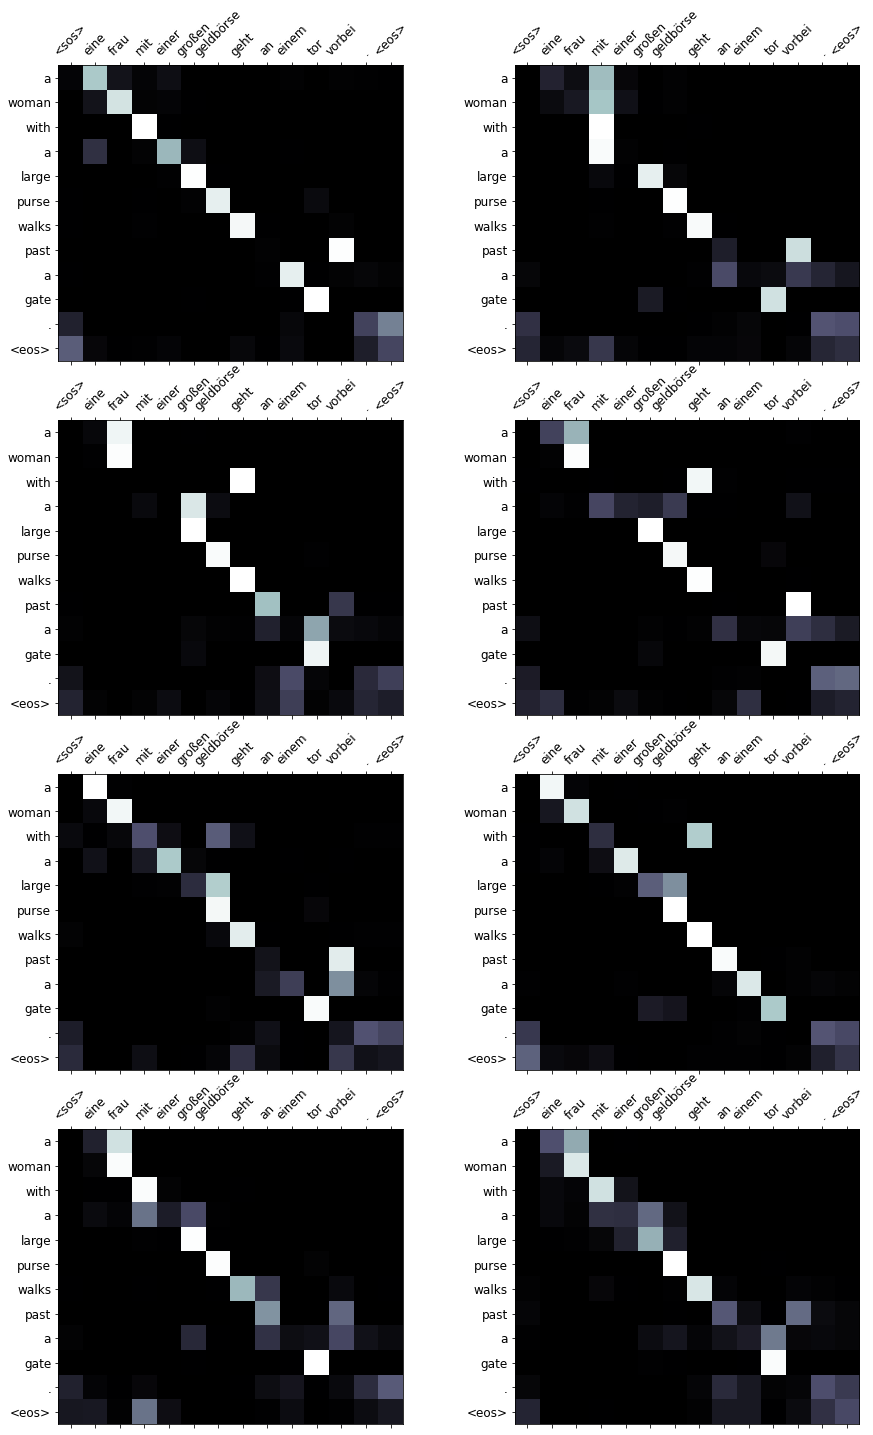

In [ ]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')
display_attention(src, translation, attention)

In [ ]:
example_idx = 6

src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['ein', 'brauner', 'hund', 'rennt', 'dem', 'schwarzen', 'hund', 'hinterher', '.']
trg = ['a', 'brown', 'dog', 'is', 'running', 'after', 'the', 'black', 'dog', '.']


predicted trg = ['a', 'brown', 'dog', 'is', 'running', 'after', 'the', 'black', 'dog', '.', '<eos>']


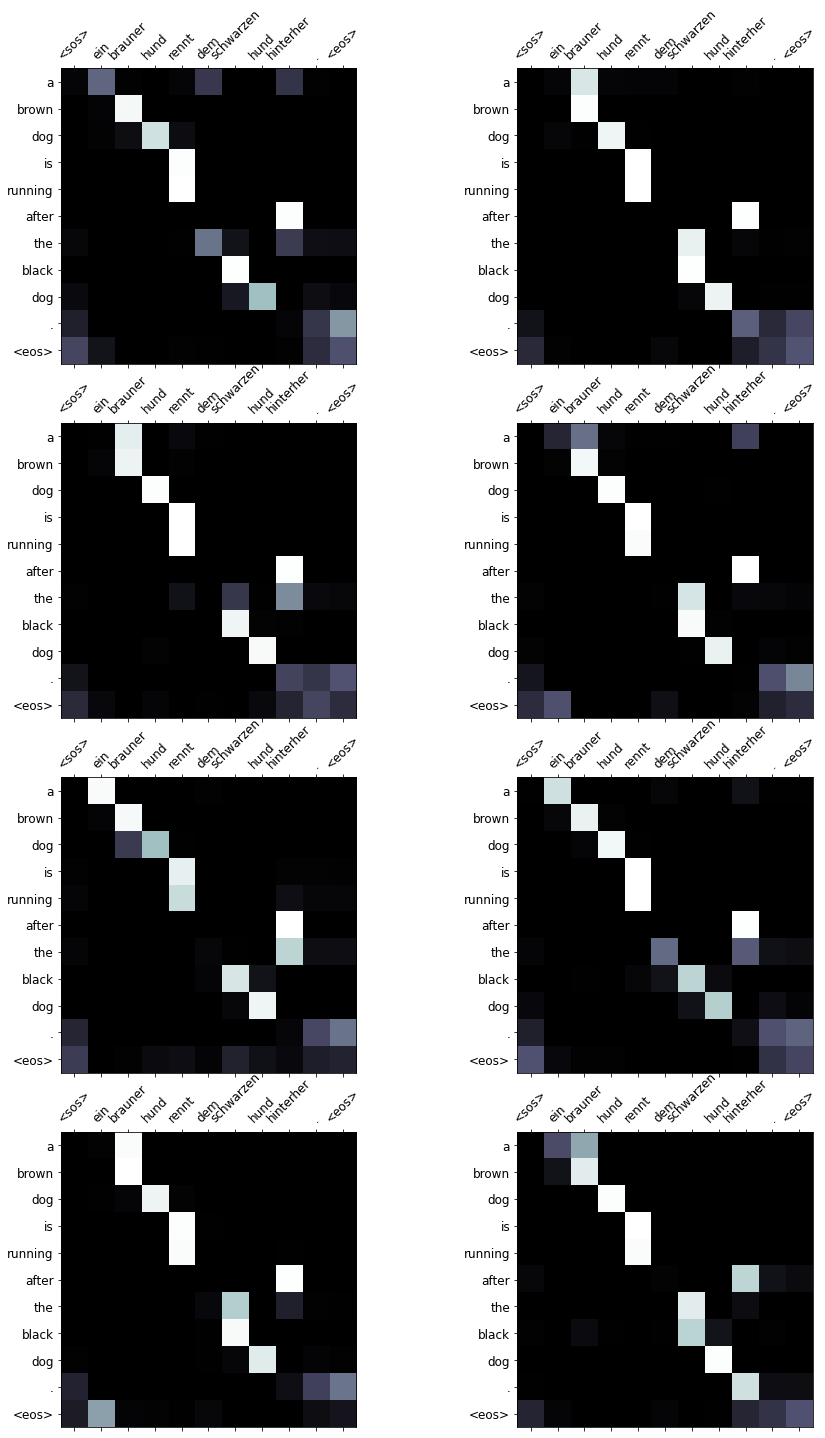

In [ ]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')
display_attention(src, translation, attention)

## BLEU Score

[Blue score method](https://pytorch.org/text/_modules/torchtext/data/metrics.html)

In [ ]:
import math
import collections
import torch
from torchtext.data.utils import ngrams_iterator


def _compute_ngram_counter(tokens, max_n):
    """ Create a Counter with a count of unique n-grams in the tokens list

    Arguments:
        tokens: a list of tokens (typically a string split on whitespaces)
        max_n: the maximum order of n-gram wanted

    Outputs:
        output: a collections.Counter object with the unique n-grams and their
            associated count

    Examples:
        >>> from torchtext.data.metrics import _compute_ngram_counter
        >>> tokens = ['me', 'me', 'you']
        >>> _compute_ngram_counter(tokens, 2)
            Counter({('me',): 2,
             ('you',): 1,
             ('me', 'me'): 1,
             ('me', 'you'): 1,
             ('me', 'me', 'you'): 1})
    """
    assert max_n > 0
    ngrams_counter = collections.Counter(tuple(x.split(' '))
                                         for x in ngrams_iterator(tokens, max_n))

    return ngrams_counter


def bleu_score(candidate_corpus, references_corpus, max_n=4, weights=[0.25] * 4):
    """Computes the BLEU score between a candidate translation corpus and a references
    translation corpus. Based on https://www.aclweb.org/anthology/P02-1040.pdf

    Arguments:
        candidate_corpus: an iterable of candidate translations. Each translation is an
            iterable of tokens
        references_corpus: an iterable of iterables of reference translations. Each
            translation is an iterable of tokens
        max_n: the maximum n-gram we want to use. E.g. if max_n=3, we will use unigrams,
            bigrams and trigrams
        weights: a list of weights used for each n-gram category (uniform by default)

    Examples:
        >>> from torchtext.data.metrics import bleu_score
        >>> candidate_corpus = [['My', 'full', 'pytorch', 'test'], ['Another', 'Sentence']]
        >>> references_corpus = [[['My', 'full', 'pytorch', 'test'], ['Completely', 'Different']], [['No', 'Match']]]
        >>> bleu_score(candidate_corpus, references_corpus)
            0.8408964276313782
    """

    assert max_n == len(weights), 'Length of the "weights" list has be equal to max_n'
    assert len(candidate_corpus) == len(references_corpus),\
        'The length of candidate and reference corpus should be the same'

    clipped_counts = torch.zeros(max_n)
    total_counts = torch.zeros(max_n)
    weights = torch.tensor(weights)

    candidate_len = 0.0
    refs_len = 0.0

    for (candidate, refs) in zip(candidate_corpus, references_corpus):
        candidate_len += len(candidate)

        # Get the length of the reference that's closest in length to the candidate
        refs_len_list = [float(len(ref)) for ref in refs]
        refs_len += min(refs_len_list, key=lambda x: abs(len(candidate) - x))

        reference_counters = _compute_ngram_counter(refs[0], max_n)
        for ref in refs[1:]:
            reference_counters = reference_counters | _compute_ngram_counter(ref, max_n)

        candidate_counter = _compute_ngram_counter(candidate, max_n)

        clipped_counter = candidate_counter & reference_counters

        for ngram in clipped_counter:
            clipped_counts[len(ngram) - 1] += clipped_counter[ngram]

        for ngram in candidate_counter:  # TODO: no need to loop through the whole counter
            total_counts[len(ngram) - 1] += candidate_counter[ngram]

    if min(clipped_counts) == 0:
        return 0.0
    else:
        pn = clipped_counts / total_counts
        log_pn = weights * torch.log(pn)
        score = torch.exp(sum(log_pn))

        bp = math.exp(min(1 - refs_len / candidate_len, 0))

        return bp * score.item()

In [ ]:
def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):
    
    trgs = []
    pred_trgs = []
    
    for datum in data:
        
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
        
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        
    return bleu_score(pred_trgs, trgs)

In [ ]:
bleu_score = calculate_bleu(test_data, SRC, TRG, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 35.33
